# For opening and working with the parameter files. These values are saved to file or taken direct from a bound c++ attribute

(500, 11)
(500, 11)
[5.79035e-05 6.85179e+02 1.51898e-05 5.06321e+00 7.91603e-02 9.27533e-03]
(6,)


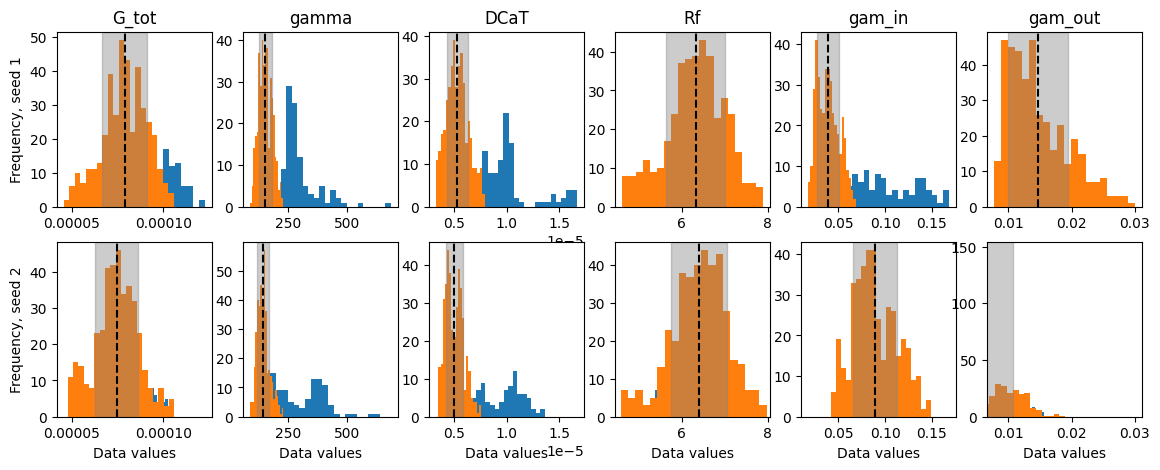

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle 

param_sample_file = r"sample_data/output/param_samples_default_janelia_seed1.dat"
param_sample_file2 = r"sample_data/output/param_samples_default_janelia_seed2.dat"
param_samples = np.loadtxt(param_sample_file,skiprows=1,delimiter=",")
param_samples2 = np.loadtxt(param_sample_file2,skiprows=1,delimiter=",")
param_names = ['G_tot','gamma','DCaT','Rf','gam_in','gam_out']

print(param_samples.shape)
print(param_samples2.shape)
good_params = param_samples[:,0:6]
good_params2 = param_samples2[:,0:6]
print(good_params[0,:])
Cparams = np.mean(good_params,axis=0)
Cparams2 = np.mean(good_params2,axis=0)
print(Cparams.shape)

#hostograms of each
n_columns = good_params.shape[1]
fig,axes = plt.subplots(2,n_columns,figsize=(14,5))
for col_idx in range(n_columns):
  # Get the current column data
  column_data = np.array([good_params[:, col_idx],good_params2[:,col_idx]]).T

  for row in range(2):
    
    # Plot the histogram as a stacked bar (adjust bins as needed)
    axes[row,col_idx].hist(column_data[0:100,row], bins=20, stacked=True)
    axes[row,col_idx].hist(column_data[101:,row], bins=20, stacked=True)
    axes[row,col_idx].axvline(np.mean(column_data[101:,row]),color='black',linestyle='dashed')

    # Define the rectangle properties (adjust alpha for transparency)
    rect = Rectangle(xy=(np.mean(column_data[101:,row]) - np.std(column_data[101:,row]), 0),\
      width=2 * np.std(column_data[101:,row]), height=max(axes[row,col_idx].get_ylim()),\
      alpha=0.4, color='gray')  # Light blue shade

    # Add the rectangle to the current subplot
    axes[row,col_idx].add_patch(rect)
    if col_idx==0:
      if row==0:
        axes[row,col_idx].set_ylabel("Frequency, seed 1")
      if row==1:
        axes[row,col_idx].set_ylabel("Frequency, seed 2")

    if row==1:
      axes[row,col_idx].set_xlim(axes[0,col_idx].get_xlim())

  # Set labels and title for each subplot (optional)
  axes[1,col_idx].set_xlabel("Data values")
  
  axes[0,col_idx].set_title(param_names[col_idx])

# Show the plot
plt.show()


In [4]:
def open_Janelia_1(j_path):
    all_data = sio.loadmat(j_path)
    data = all_data['dff']
    time = all_data['time_stamps']

    return time, data

In [3]:
def calculate_standardized_noise(dff,time):
    frame_rate = 1/np.mean(np.diff(time))
    noise_levels = np.nanmedian(np.abs(np.diff(dff, axis=-1)), axis=-1) / np.sqrt(frame_rate)
    return noise_levels * 100 ,frame_rate    # scale noise levels to percent

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

noise_dir="gt_noise_dir"
current_dir = os.path.join(os.getcwd(),'src','spike_find','syn_gen')
full_noise_path = os.path.join(current_dir, noise_dir)
noise_files = [os.path.join(full_noise_path, f) for f in os.listdir(full_noise_path) if f.endswith('.mat')]

#Stuff about the noise vignetted files
sub_jan = "471994_1"
sub_man = "_0_mini"
for file in noise_files:
    if sub_jan in file:
        print(file)
        good_file = file
#print(f"good_file = {good_file}")

noise,noise_time = open_cascade_noise(good_file,1)
std_noise_noise,frame_rate = calculate_standardized_noise(noise.T,noise_time.T)
#print(f"noise_is_nan = {np.sum(np.isnan(noise_time))}, noise head = {noise[0:5]}")
#print(f"noise.shape = {noise.shape}")
print(f"std_noise_noise = {std_noise_noise} and frame_rate = {frame_rate}")

#Stuff about the janelia files I processed
janelia_file = "jGCaMP8f_ANM471994_cell01"

real_fname = os.path.join("gt_data",janelia_file+".mat")

time,data = open_Janelia_1(real_fname)

std_noise,frame_rate = calculate_standardized_noise(data,time)
print(f"{janelia_file} std_noise = {std_noise} and frame_rate = {frame_rate}")



/scratch/gpfs/gerardjb/TEST2/src/spike_find/syn_gen/gt_noise_dir/CAttached_jGCaMP8f_471994_1_mini.mat


NameError: name 'open_cascade_noise' is not defined

(80.0, 100.0)

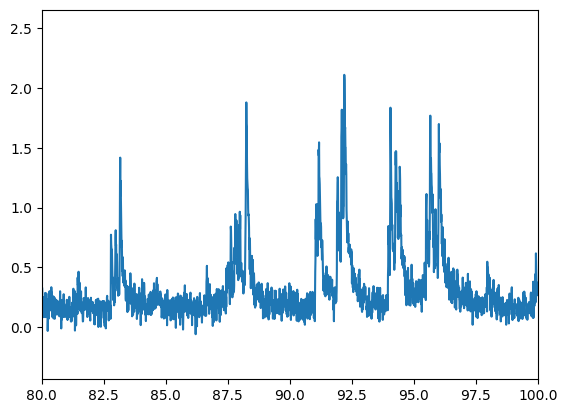

In [9]:
#Plotting things
plt.figure()
plt.plot(time[0,:].T, data[0,:].T)
ax = plt.gca()
ax.set_xlim([80,100])

In [5]:
def open_cascade_noise(cas_path,selected_epoch):
    noise_data = sio.loadmat(cas_path)['CAttached']
    #print(noise_data[0][0].dtype.descr)
    noise = noise_data[0][selected_epoch]['gt_noise'][0][0]
    time = noise_data[0][selected_epoch]['fluo_time'][0][0]

    return noise,time
    

In [23]:
file = noise_files[0]
noise_data = sio.loadmat(file)
CAttached = noise_data['CAttached']
keys = CAttached[0][0].dtype.descr

for ii in np.arange(len(CAttached[0])):
    # Add new field for noise + simulation
    new_inner_dtype = np.dtype(CAttached[0][ii].dtype.descr + \
    [('fluo_mean', '|O')] + [('events_AP','|O')])
    
    #Set up structure to hold fluo_mean
    inner_array = CAttached[0][ii]
    new_inner_array = np.empty(inner_array.shape, dtype=new_inner_dtype)
    
    # Copy existing data to the new structured array
    for field in inner_array.dtype.names:
        new_inner_array[field] = inner_array[field]
        
    #Noise, time, get spikes
    noise = inner_array['gt_noise'][0][0]
    time = inner_array['fluo_time'][0][0]
    print(time.shape)
    T = time[-1] - time[0]
    
    #Check standardized noise and toss if over criterion
    if True:
      frame_rate = 1/np.mean(np.diff(time))
      standard_noise,frame_rate = calculate_standardized_noise(noise.T,time.T)
      print(standard_noise)
      if standard_noise>2:
        print('Failed criterion')
      else:
        print('Passed criterion')

(14356, 1)
[1.9952453]
Passed criterion
(10646, 1)
[3.058825]
Failed criterion
(14218, 1)
[2.2015235]
Failed criterion
(12202, 1)
[2.3653717]
Failed criterion


# Plotting the outputs of the inference probability traces

(9, 19520)


(1083.0, 1086.0)

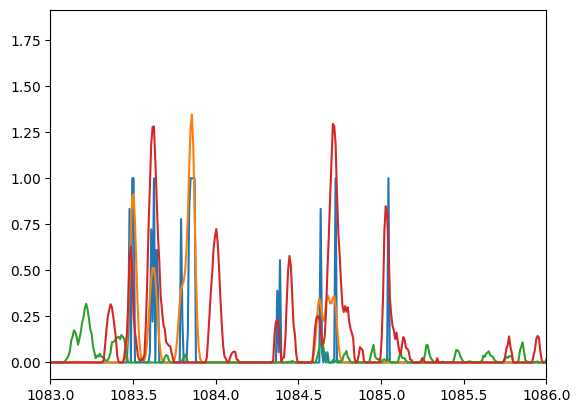

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

# This is for plotting the outcomes
#Loading data
biophys_file = r"sample_data/predictions/biophysd_jGCaMP8f_ANM471993_cell03.mat"
b_MC = sio.loadmat(biophys_file)
b_cascade_file = r"sample_data/predictions/Cascaded_jGCaMP8f_ANM471993_cell03.mat"
b_cas = sio.loadmat(b_cascade_file)
new_pred_file = r"sample_data/predictions/default_janelia_cRNN_no_relu_output.mat"
new_pred = sio.loadmat(new_pred_file)
new_pred_file2 = r"sample_data/predictions/default_janelia_test_cRNN_no_relu_output.mat"
new_pred2 = sio.loadmat(new_pred_file2)

#plots
plt.figure()
window = np.array([1083,1086])
print(b_cas['spike_prob'].shape)
plt.plot(b_MC['time_stamps'][0,:].T,b_MC['spike_prob'][0,:].T/np.max(b_MC['spike_prob'][0,:]))
plt.plot(b_cas['time_stamps'][0,:].T,b_cas['spike_prob'][0,:].T/np.max(b_cas['spike_prob'][0,10000:15000]))
plt.plot(b_cas['time_stamps'][0,:].T,new_pred['spike_prob'][0,:].T/np.max(new_pred['spike_prob'][0,10000:15000]))
plt.plot(b_cas['time_stamps'][0,:].T,new_pred2['spike_prob'][0,:].T/np.max(new_pred2['spike_prob'][0,10000:15000]))
ax = plt.gca()
ax.set_xlim(window)

# Checking data integrity of the generated synth_gen files

spikes from mine shape on load
(13, 1)
spikes from Ruprecht shape on load
(526, 1)


(10.0, 20.0)

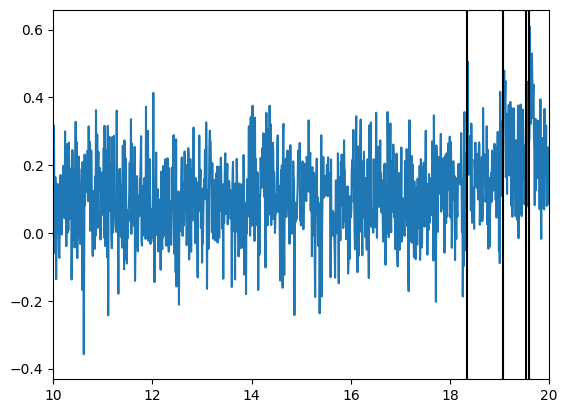

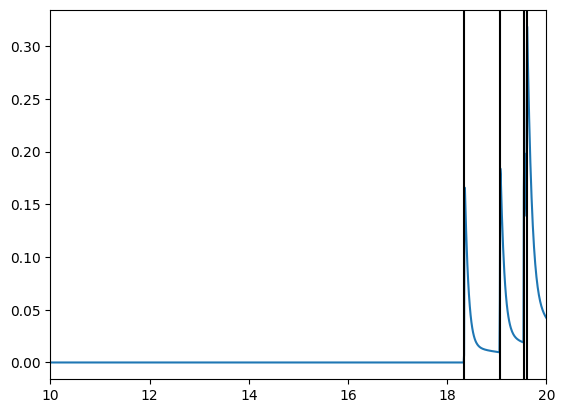

In [1]:
import matplotlib.pyplot as plt
import scipy.io as sio

test_file = r"/scratch/gpfs/gerardjb/TEST2/Ground_truth/synth_default_janelia_test/rate=1.0param=5_0.5CAttached_jGCaMP8f_471993_1_mini.mat"
test_file2 = r"/scratch/gpfs/gerardjb/TEST2/Ground_truth/DS01-OGB1-m-V1/CAttached_Theis16_set2_OGB_V1_cell_10_mini.mat"

data = sio.loadmat(test_file)['CAttached']
spikes = data[0][0]['events_AP'][0][0]
print('spikes from mine shape on load')
print(spikes.shape)
data2 = sio.loadmat(test_file2)['CAttached']
spikes2 = data2[0][0]['events_AP'][0][0]
print('spikes from Ruprecht shape on load')
print(spikes2.shape)

plt.figure()
plt.plot(data[0][0]['fluo_time'][0][0],data[0][0]['fluo_mean'][0][0].T)
for spike in spikes:
    plt.axvline(x=spike/10000,color='k',linestyle='-')
plt.gca().set_xlim([10,20])

plt.figure()
plt.plot(data[0][0]['fluo_time'][0][0],data[0][0]['fluo_mean'][0][0].T-data[0][0]['gt_noise'][0][0])
for spike in spikes:
    plt.axvline(x=spike/10000,color='k',linestyle='-')
plt.gca().set_xlim([10,20])

Ground_truth/synth_testG_tot = 0.000135169; gam_out = 0.00363831
G1 = 5.13909e-07; G6 = 0.955939
kon_N = 0.94944; koffPN2 = 386.105
N spike = 18; total Ca = 4.63147
G_tot = 0.000135169; gam_out = 0.00363831
G1 = 5.13909e-07; G6 = 0.955939
kon_N = 0.94944; koffPN2 = 386.105

spike_params[0] = 5
T = [105.] and dt = 0.25


/home/gerardjb/.conda/envs/spike_find/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gerardjb/.conda/envs/spike_find/lib/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


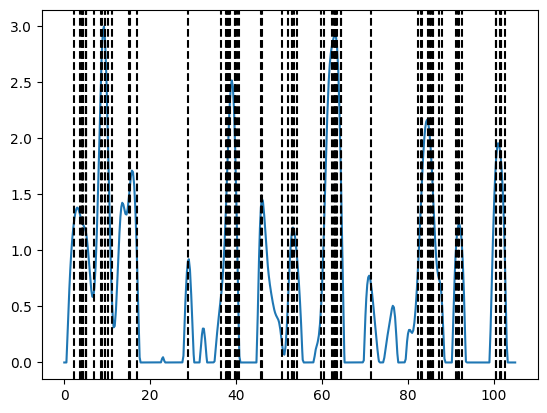

N spike = 68; total Ca = 17.4966
CAttached[0][ii].dtype.descr =  [('gt_noise', '|O'), ('fluo_time', '|O'), ('fluo_mean', '|O'), ('events_AP', '|O')]
spike_params[0] = 5
T = [64.] and dt = 0.25


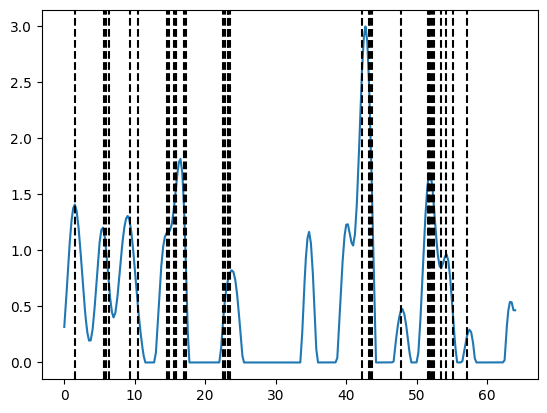

N spike = 32; total Ca = 8.23372
CAttached[0][ii].dtype.descr =  [('gt_noise', '|O'), ('fluo_time', '|O'), ('fluo_mean', '|O'), ('events_AP', '|O')]
spike_params[0] = 5
T = [69.] and dt = 0.25


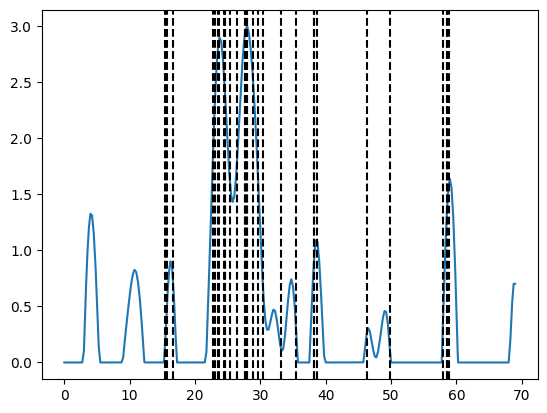

N spike = 32; total Ca = 8.23372
CAttached[0][ii].dtype.descr =  [('gt_noise', '|O'), ('fluo_time', '|O'), ('fluo_mean', '|O'), ('events_AP', '|O')]
spike_params[0] = 5
T = [122.] and dt = 0.25


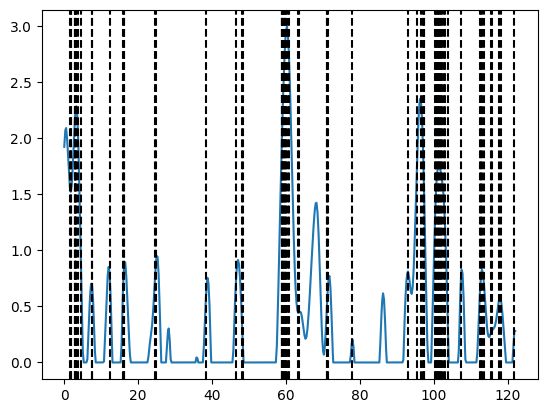

N spike = 66; total Ca = 16.982
CAttached[0][ii].dtype.descr =  [('gt_noise', '|O'), ('fluo_time', '|O'), ('fluo_mean', '|O'), ('events_AP', '|O')]
spike_params[0] = 5
T = [30.] and dt = 0.25


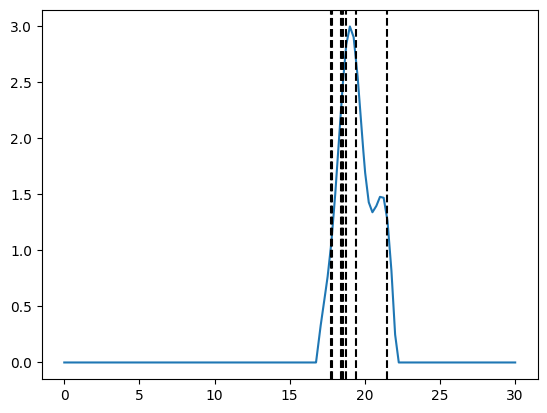

N spike = 8; total Ca = 2.05843
CAttached[0][ii].dtype.descr =  [('gt_noise', '|O'), ('fluo_time', '|O'), ('fluo_mean', '|O'), ('events_AP', '|O')]
save_path =  Ground_truth/synth_test/rate=3param=5_0.5CAttached_jGCaMP8f_471993_1_mini.mat


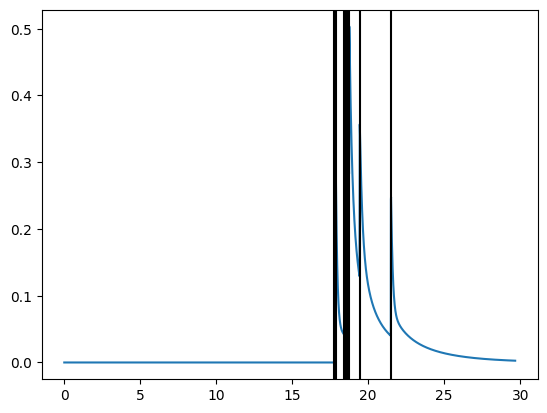

In [1]:
#Okay, so it looks like the synthetic data trace is full of nan. SO now I'll try to recreate the problem with the 
#exact inputs used to create $this file to isolate the problem

import numpy as np
import matplotlib.pyplot as plt
import build.pgas_bound as pgas
from src.spike_find.syn_gen import synth_gen

#Get and check Cparams
param_sample_file = "sample_data/output/param_samples_default_janelia_sample_excitatory3_1.dat"
parameter_samples = np.loadtxt(param_sample_file,delimiter=',',skiprows=1)
#print(parameter_samples.shape)
burnin = 100
parameter_samples = parameter_samples[burnin:,0:6]
#print("mean of samples (Cparams)")
#print(np.mean(parameter_samples,axis=0))
#Got validated Cparams
Cparams = np.mean(parameter_samples,axis=0)

#Get and check Gparams
Gparam_file="src/spike_find/pgas/20230525_gold.dat"
Gparams = np.loadtxt(Gparam_file)
#Got validated Gparams
#print("Gparams")
#print(Gparams)

#Ah, it looks like I accidentally used the final params in the
#current version of TEST2.py - changing that for now to see
#if issue resolves with a basic input first, then through synth_gen
gcamp = pgas.GCaMP(Gparams,Cparams)
sampling_rate = 1000
sim_start = -.05
sim_end = 1.5
sim_time = np.linspace(sim_start,sim_end,num=np.int(np.round((sim_end-sim_start)*sampling_rate)))
poisson_rate = 10
event_counts = np.random.poisson(poisson_rate / sampling_rate, len(sim_time))
event_trace = np.where(event_counts > 0, 1, 0)
poisson_stim = sim_time[np.where(event_trace)]
gcamp.integrateOverTime(sim_time.astype(float),poisson_stim.astype(float))
sim = gcamp.getDFFValues()
#plot looks ok
#plt.figure()
#plt.plot(sim_time,sim)

#Now onto the synth_gen piece - minimal input
gcamp = pgas.GCaMP(Gparams,Cparams)#making a new gcamp, same params
synth = synth_gen.synth_gen(plot_on=True,GCaMP_model=gcamp,\
    spike_rate=3,cell_params=Cparams,tag='test',use_noise=True,\
    noise_dir='gt_noise_dir/gt_noise_test')
synth.generate()